In [1]:
import plot_utils
import test_utils
import architecture
import prepro
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
batch_size = 32
epochs = 60
random_state = 21

#number of depth images to keep, only a certain number contains the base gangli
zmin = 20
zmax = 30

#portion of image which contains the interested part of brain scan
xmin = 33
xmax = 162
ymin = 73
ymax = 202

deltaX = xmax-xmin
deltaY = ymax-ymin
deltaZ = zmax-zmin

irangemin = zmin
irangemax = zmax

img_size = deltaX+1

num_classes = 2

#during data augmentation the images will be shifted in the 4 directions of 5% and 10% of the width
shifting_percentages = [img_size*0.05, img_size*0.1, -img_size*0.05, -img_size*0.1]

In [3]:
project_dir = os.getcwd()

try_num = 1
try_dir = os.path.join(project_dir, 'try_{try_num}'.format(try_num=try_num))
if os.path.exists(try_dir):
    raise Exception("Directory name already used, update try_num")
else:
    os.mkdir(try_dir)

In [4]:
data_folder = os.path.join(project_dir, 'CDOPA_dataset')
csv_path = os.path.join(project_dir, 'carbidopa.csv')

model_filepath = os.path.join(try_dir, 'model.h5')
summary_filepath = os.path.join(try_dir, 'model_summary.txt')
hist_csv_filepath = os.path.join(try_dir, 'history.csv')

In [ ]:
patients = os.listdir(data_folder)
patients.sort()
num_patients = len(patients)

df_csv = pd.read_csv(csv_path)
df_csv['GUID'] = df_csv['GUID'].astype(str)
df_sorted = df_csv.sort_values('GUID')
df_sorted = df_sorted.iloc[0:num_patients,:]#in the csv there are more datapoints than in the CDOPA_dataset folder

Y_D = np.array(df_sorted[['GUID','LABEL']])
Y_DATA = np.array(df_sorted[['LABEL']])
X_DATA = prepro.create_dataset(data_folder)

In [11]:
X_DATA, X_DATA_TEST, Y_DATA, Y_DATA_TEST, Y_D, Y_D_TEST = train_test_split(X_DATA, Y_DATA, Y_D, test_size=0.30, random_state=random_state)

In [ ]:
X_DATA_NEW, Y_D_NEW, Y_DATA_NEW = prepro.get_shifted_dataset(X_DATA, Y_D, Y_DATA, shifting_percentages=shifting_percentages)

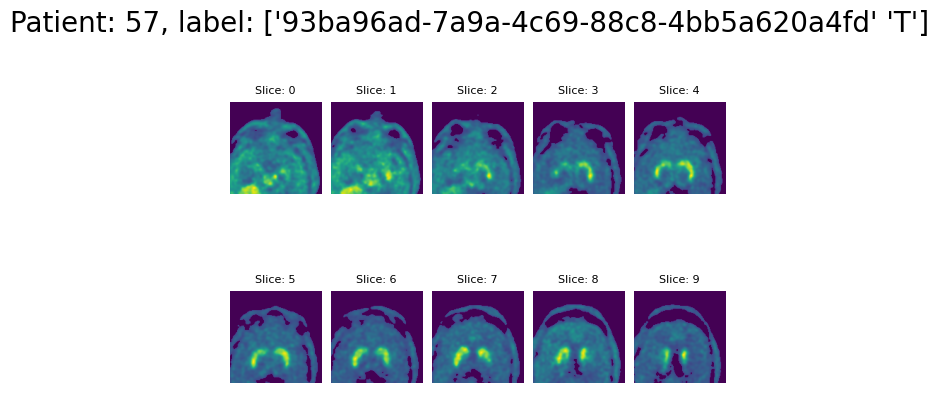

In [48]:
plot_utils.plot_slices(X_DATA, Y_D)

In [14]:
X_DATA_NEW, Y_DATA_NEW = prepro.prep_dataset(X_DATA_NEW, Y_DATA_NEW, num_classes=num_classes)

In [15]:
X_DATA_TRAIN, X_DATA_VAL, Y_DATA_TRAIN, Y_DATA_VAL = train_test_split(X_DATA_NEW, Y_DATA_NEW, test_size=0.20, random_state=random_state)

In [ ]:
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

model = architecture.build_model(img_size=img_size, num_classes=num_classes)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.Recall()]
)

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_best_only=True
    )
]

history = model.fit(
    x = X_DATA_TRAIN,
    y = Y_DATA_TRAIN,
    batch_size=batch_size,
    validation_data=(X_DATA_VAL, Y_DATA_VAL),
    epochs=epochs,
    callbacks=callbacks,
    shuffle=True,
)


hist_df = pd.DataFrame(history.history)
with open(hist_csv_filepath, mode='w') as f:
    hist_df.to_csv(f)

with open(summary_filepath, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


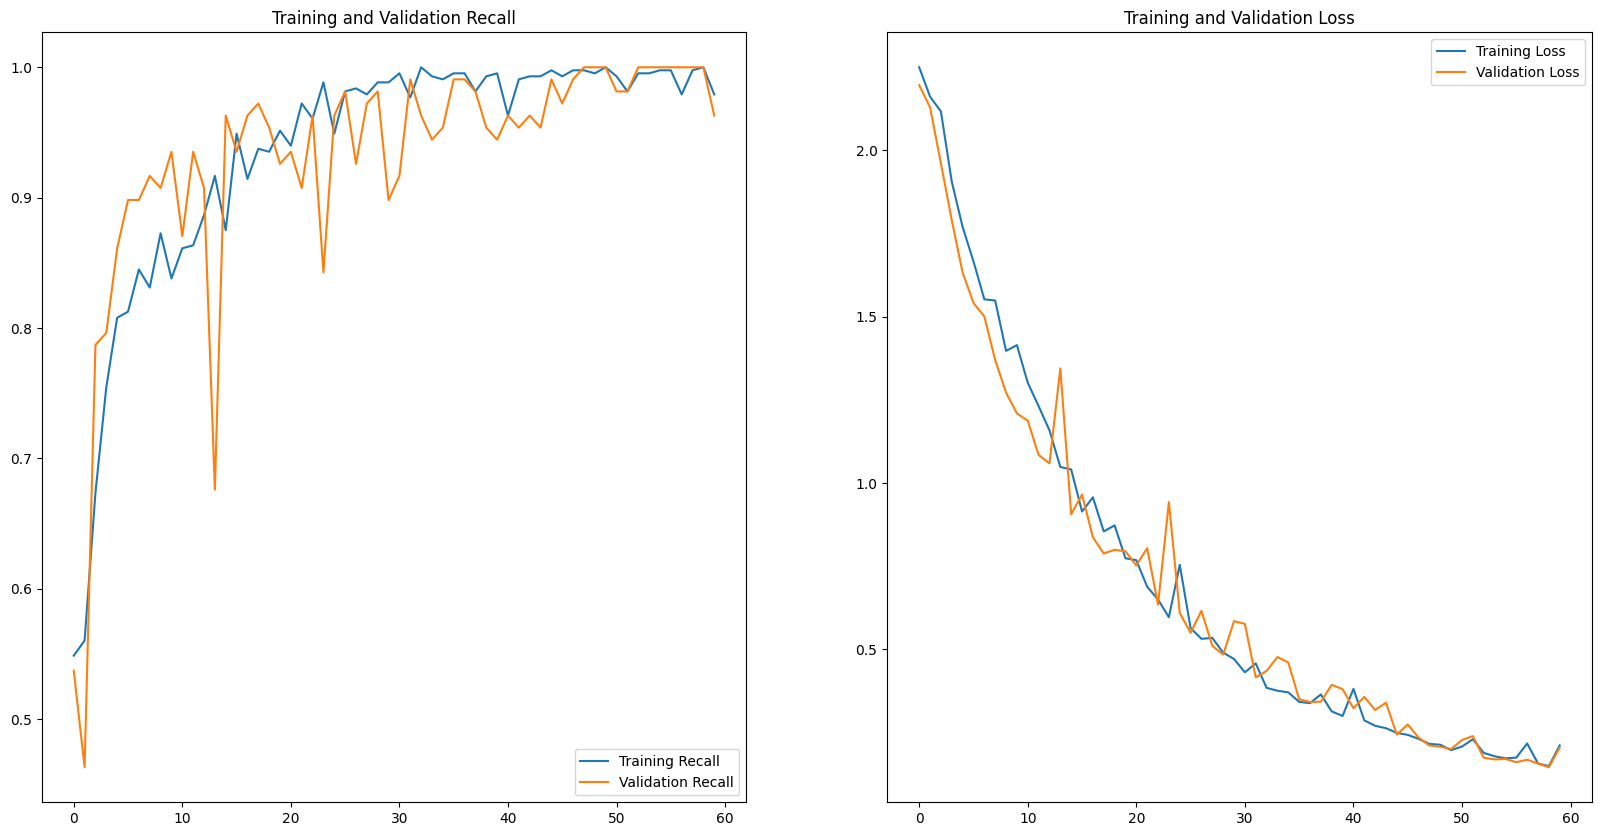

In [25]:
rec = history.history['recall']
val_rec = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_utils.plot_loss_metric(loss, val_loss, rec, val_rec, metric_name='recall')

In [18]:
X_DATA_TEST, Y_DATA_TEST = prepro.prep_dataset(X_DATA_TEST, Y_DATA_TEST, num_classes)

In [19]:
model = keras.models.load_model(model_filepath)
results = model.evaluate(X_DATA_TEST, Y_DATA_TEST)

1/1 [==============================] - 0s 282ms/step - loss: 1.5898 - recall: 0.8519


In [ ]:
predictions = model.predict(X_DATA_TEST)

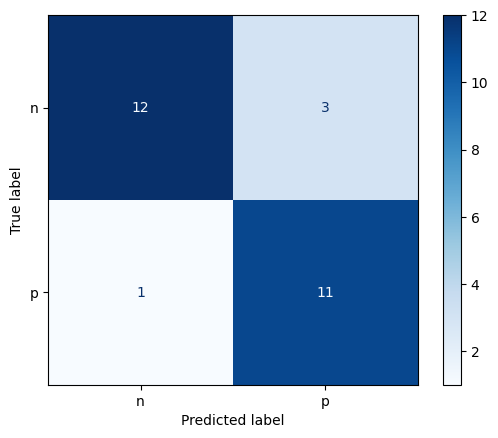

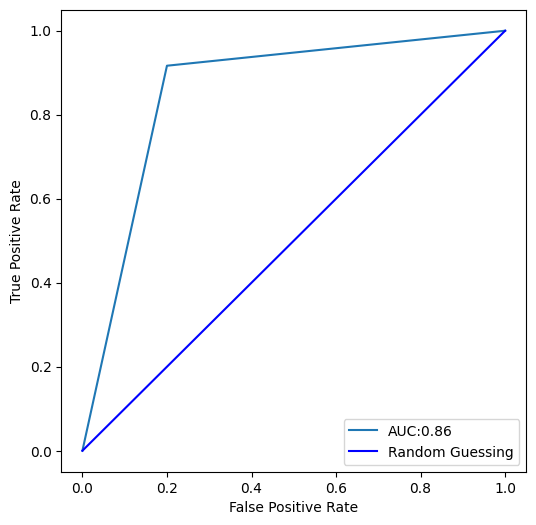

ROC AUC score: 0.8583333333333333


In [59]:
targets = ['n', 'p']
ConfusionMatrixDisplay.from_predictions(np.argmax(Y_DATA_TEST, axis=1),
                                        np.argmax(predictions, axis=1),
                                        display_labels=targets,
                                        cmap='Blues')

print('ROC AUC score:', test_utils.multiclass_roc_auc_score(np.argmax(Y_DATA_TEST, axis=1),
                                                 np.argmax(predictions, axis=1),
                                                 target_list=targets,
                                                 multiclass=False))

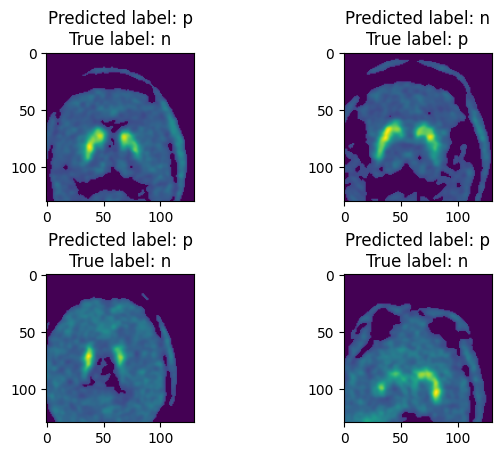

In [109]:
targets_dict = {
    '0': 'n',
    '1': 'p'
}

test_utils.display_errors(targets_dict, X_DATA_TEST[:,:,:,3], Y_DATA_TEST, predictions)